# Emotion Detection

## Import Library

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os

from warnings import filterwarnings
filterwarnings('ignore')

## Download & Load Dataset

In [ ]:
os.environ['KAGGLE_USERNAME'] = "nicoldeb"
os.environ['KAGGLE_KEY'] = "60d268a7145e944777ccbfd26927d9c0"

In [ ]:
%pip install kaggle

In [ ]:
!kaggle datasets download -d gerhardien/text-emotion-indonesia

Dataset URL: https://www.kaggle.com/datasets/gerhardien/text-emotion-indonesia
License(s): MIT
  0% 0.00/502k [00:00<?, ?B/s]
100% 502k/502k [00:00<00:00, 19.6MB/s]


In [ ]:
with zipfile.ZipFile('text-emotion-indonesia.zip', 'r') as zip_ref:
    zip_ref.extractall('text-emotion')

In [ ]:
# Load the dataset
df = pd.read_csv('text-emotion/train_filtered.csv')

# Display the first few rows of the dataset
df

,label,sentence
0,sadness,aku telah belajar bahwa bahkan ketika aku mera...
1,sadness,aku tahu bagaimana rasanya menderita sakit dan...
2,neutral,Ucapkan selamat tinggal pada vas defferens dan...
3,neutral,Aku tak sabar menunggu Narratif ini berhenti.
4,neutral,Aku meninggalkannya karena aku mencoba untuk m...
...,...,...
12235,sadness,Aku telah menyakiti begitu banyak dan diberita...
12236,neutral,Ini bukan tentang tidak mengerti bahwa kau sal...
12237,joy,aku merasa cukup penuh harapan pagi ini bahwa ...
12238,neutral,Bagaimana kalau sekarang?


In [ ]:
# Inspect the label column to understand the data
print(df['label'].unique())

['sadness' 'neutral' 'joy' 'anger']


## Data Preprocess

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels to integers
df['label'] = label_encoder.fit_transform(df['label'])

# Verify the transformation
print(df['label'].unique())

[3 2 1 0]


In [ ]:
!pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 9.6 MB/s eta 0:00:00


In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import string

from transformers import BertTokenizer
from transformers import AutoTokenizer, AutoModel
from nltk.corpus import stopwords
import re
import nltk

# Download stopwords if not already downloaded
nltk.download('stopwords')

def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Menghapus mention (@username)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # Menghapus hashtag
    text = re.sub(r'RT[\s]', '', text)  # Menghapus RT (Retweet)
    text = re.sub(r"http\S+", '', text)  # Menghapus URL
    text = re.sub(r'[0-9]+', '', text)  # Menghapus angka
    text = re.sub(r'[^\w\s]', '', text)  # Menghapus karakter non-alfanumerik

    text = text.replace('\n', ' ')  # Menghapus newline
    text = text.translate(str.maketrans('', '', string.punctuation))  # Menghapus tanda baca
    text = text.strip()  # Menghapus spasi ekstra di awal & akhir

    return text

def casefoldingText(text):
    return text.lower()

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('indolem/indobert-base-uncased')
# Function to tokenize text
def tokenizingText(text):
    return tokenizer.tokenize(text)

# Download stopwords if not already downloaded
nltk.download('stopwords')
# List Stopwords
factory = StopWordRemoverFactory()
listStopwords = set(factory.get_stop_words())  # Stopword bahasa Indonesia
listStopwords1 = set(stopwords.words('english'))  # Stopword bahasa Inggris
listStopwords.update(listStopwords1)
listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])

# Preprocessing function
def filteringText(text):
    return [word for word in text if word not in listStopwords]

def joinText(text):
  return ' '.join(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
clean_df = df.copy()

clean_df['text_clean'] = clean_df['sentence'].apply(cleaningText)
clean_df['text_lowercase'] = clean_df['text_clean'].apply(casefoldingText)
clean_df['text_tokenizing'] = clean_df['text_lowercase'].apply(tokenizingText)
clean_df['text_final'] = clean_df['text_tokenizing'].apply(joinText)

clean_df

,label,sentence,text_clean,text_lowercase,text_tokenizing,text_final
0,3,aku telah belajar bahwa bahkan ketika aku mera...,aku telah belajar bahwa bahkan ketika aku mera...,aku telah belajar bahwa bahkan ketika aku mera...,"[aku, telah, belajar, bahwa, bahkan, ketika, a...",aku telah belajar bahwa bahkan ketika aku mera...
1,3,aku tahu bagaimana rasanya menderita sakit dan...,aku tahu bagaimana rasanya menderita sakit dan...,aku tahu bagaimana rasanya menderita sakit dan...,"[aku, tahu, bagaimana, rasanya, menderita, sak...",aku tahu bagaimana rasanya menderita sakit dan...
2,2,Ucapkan selamat tinggal pada vas defferens dan...,Ucapkan selamat tinggal pada vas defferens dan...,ucapkan selamat tinggal pada vas defferens dan...,"[ucapkan, selamat, tinggal, pada, vas, def, ##...",ucapkan selamat tinggal pada vas def ##fer ##e...
3,2,Aku tak sabar menunggu Narratif ini berhenti.,Aku tak sabar menunggu Narratif ini berhenti,aku tak sabar menunggu narratif ini berhenti,"[aku, tak, sabar, menunggu, nar, ##rat, ##if, ...",aku tak sabar menunggu nar ##rat ##if ini berh...
4,2,Aku meninggalkannya karena aku mencoba untuk m...,Aku meninggalkannya karena aku mencoba untuk m...,aku meninggalkannya karena aku mencoba untuk m...,"[aku, meninggalkannya, karena, aku, mencoba, u...",aku meninggalkannya karena aku mencoba untuk m...
...,...,...,...,...,...,...
12235,3,Aku telah menyakiti begitu banyak dan diberita...,Aku telah menyakiti begitu banyak dan diberita...,aku telah menyakiti begitu banyak dan diberita...,"[aku, telah, menyakiti, begitu, banyak, dan, d...",aku telah menyakiti begitu banyak dan diberita...
12236,2,Ini bukan tentang tidak mengerti bahwa kau sal...,Ini bukan tentang tidak mengerti bahwa kau sal...,ini bukan tentang tidak mengerti bahwa kau sal...,"[ini, bukan, tentang, tidak, mengerti, bahwa, ...",ini bukan tentang tidak mengerti bahwa kau sal...
12237,1,aku merasa cukup penuh harapan pagi ini bahwa ...,aku merasa cukup penuh harapan pagi ini bahwa ...,aku merasa cukup penuh harapan pagi ini bahwa ...,"[aku, merasa, cukup, penuh, harapan, pagi, ini...",aku merasa cukup penuh harapan pagi ini bahwa ...
12238,2,Bagaimana kalau sekarang?,Bagaimana kalau sekarang,bagaimana kalau sekarang,"[bagaimana, kalau, sekarang]",bagaimana kalau sekarang


In [ ]:
from transformers import BertForSequenceClassification

# Define the model
num_labels = clean_df['label'].nunique()
model = BertForSequenceClassification.from_pretrained('indolem/indobert-base-uncased', num_labels=num_labels)

# Display the model architecture
print(model)

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31923, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
import torch
import numpy as np

# Splitting the data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(clean_df['text_final'], clean_df['label'], test_size=0.3, random_state=42)

# Tokenizing the data
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=512)

# Convert to torch tensors
train_input_ids = torch.tensor(train_encodings['input_ids'])
train_attention_masks = torch.tensor(train_encodings['attention_mask'])
train_labels = torch.tensor(train_labels.values)

val_input_ids = torch.tensor(val_encodings['input_ids'])
val_attention_masks = torch.tensor(val_encodings['attention_mask'])
val_labels = torch.tensor(val_labels.values)

# Create TensorDataset
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)

# DataLoader for training and validation
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=16)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=16)

In [ ]:
from sklearn.metrics import accuracy_score

# Define the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * 3  # 3 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

def train(model, train_dataloader, val_dataloader, epochs):
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        train_preds = []
        train_labels_all = []

        for step, batch in enumerate(train_dataloader):
            b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

            model.zero_grad()
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1).flatten()
            train_preds.extend(preds.cpu().numpy())
            train_labels_all.extend(b_labels.cpu().numpy())

            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(train_dataloader)
        train_accuracy = accuracy_score(train_labels_all, train_preds)

        print(f"\nEpoch {epoch + 1}/{epochs}")
        print(f"Training loss: {avg_train_loss:.4f}")
        print(f"Training accuracy: {train_accuracy * 100:.2f}%")

        model.eval()
        eval_loss = 0
        eval_steps = 0
        val_preds = []
        val_labels_all = []

        for batch in val_dataloader:
            b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
            with torch.no_grad():

                outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
                loss = outputs.loss
                logits = outputs.logits

                eval_loss += loss.item()
                eval_steps += 1

                preds = torch.argmax(logits, dim=1).flatten()
                val_preds.extend(preds.cpu().numpy())
                val_labels_all.extend(b_labels.cpu().numpy())

        avg_val_loss = eval_loss / eval_steps
        val_accuracy = accuracy_score(val_labels_all, val_preds)

        print(f"Validation loss: {avg_val_loss:.4f}")
        print(f"Validation accuracy: {val_accuracy * 100:.2f}%")

    # Save the trained model
    model_save_path = "BERT_classification_model"
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)
    print(f"Model saved to {model_save_path}")

train(model, train_dataloader, val_dataloader, epochs=5)


Epoch 1/5
Training loss: 0.6956
Training accuracy: 71.76%
Validation loss: 0.3865
Validation accuracy: 86.41%

Epoch 2/5
Training loss: 0.3195
Training accuracy: 88.83%
Validation loss: 0.2944
Validation accuracy: 90.41%

Epoch 3/5
Training loss: 0.2120
Training accuracy: 92.75%
Validation loss: 0.2899
Validation accuracy: 90.74%

Epoch 4/5
Training loss: 0.1784
Training accuracy: 94.00%
Validation loss: 0.2899
Validation accuracy: 90.74%

Epoch 5/5
Training loss: 0.1814
Training accuracy: 94.07%
Validation loss: 0.2899
Validation accuracy: 90.74%
Model saved to BERT_classification_model


In [ ]:
from google.colab import files
import shutil

# Zip the model directory
shutil.make_archive("BERT_classification_model", 'zip', "BERT_classification_model")

# Download the zipped model directory
files.download("BERT_classification_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Eval

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate(model, val_dataloader):
    model.eval()
    predictions, true_labels = [], []
    for batch in val_dataloader:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs[0]
            predictions.append(logits.argmax(dim=1).cpu().numpy())
            true_labels.append(b_labels.cpu().numpy())

    predictions = np.concatenate(predictions)
    true_labels = np.concatenate(true_labels)

    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

evaluate(model, val_dataloader)

Accuracy: 0.9074074074074074
Precision: 0.908161781106557
Recall: 0.9074074074074074
F1 Score: 0.9072659955761632


Accuracy: 0.9074074074074074
Precision: 0.908161781106557
Recall: 0.9074074074074074
F1 Score: 0.9072659955761632


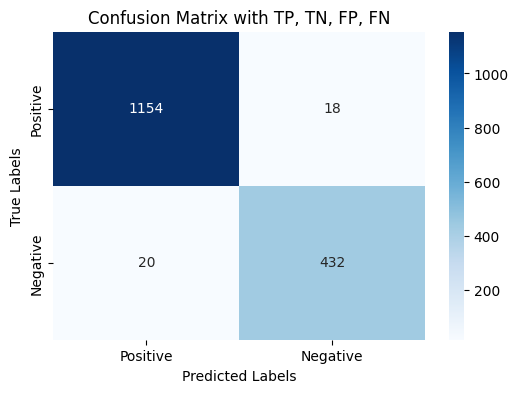

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Fungsi evaluasi
def evaluate(model, val_dataloader):
    model.eval()
    predictions, true_labels = [], []
    for batch in val_dataloader:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs[0]
            predictions.append(logits.argmax(dim=1).cpu().numpy())
            true_labels.append(b_labels.cpu().numpy())

    predictions = np.concatenate(predictions)
    true_labels = np.concatenate(true_labels)

    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Confusion matrix
    cm = confusion_matrix(true_labels, predictions)

    # Extract TP, TN, FP, FN from confusion matrix
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    # Plot confusion matrix with TP, TN, FP, FN
    plt.figure(figsize=(6, 4))
    sns.heatmap([[TP, FN], [FP, TN]], annot=True, cmap='Blues', fmt='g',
                xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix with TP, TN, FP, FN')
    plt.show()

# Memanggil fungsi evaluasi dengan model dan dataloader validasi (val_dataloader)
evaluate(model, val_dataloader)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil

source = '/content/BERT_classification_model'
destination = '/content/drive/MyDrive/Capstone/ED/BERT_classification_model'

shutil.move(source, destination)

'/content/drive/MyDrive/Capstone/ED/BERT_classification_model'